# Simplicit: Simulating Implicit Objects
The implicit simulation pipeline is divided into 7 steps.

## Preliminaries

Uncomment to install the requirements for simplicits, gaussian splatting and kaolin.

#### Gaussian Splatting

Clone and install the repo:

In [1]:
# !cd thirdparty
# !git clone git@github.com:graphdeco-inria/gaussian-splatting.git gausplat --recursive
# !cd ..

In [2]:
# Install env gaussian-splats env from: https://github.com/graphdeco-inria/gaussian-splatting

INRIA assumes `torch 1.12.1+cu116` by default, for higher torch versions like `torch 2.0.1+cu118` --update their `environment.yaml` file to i.e:

```yaml
name: toronto_gs
channels:
  - pytorch
  - nvidia
  - conda-forge
  - defaults
dependencies:
  - pytorch-cuda=11.8  # For old torch versions this is cudatoolkit=11.3
  - plyfile=0.8.1
  - python=3.8
  - pip=22.3.1
  - pytorch=2.0.1
  - torchaudio=2.0.2
  - torchvision=2.0.2
  - tqdm
  - pip:
    - submodules/diff-gaussian-rasterization
    - submodules/simple-knn
```
And then build their env:
```bash
# May take awhile, see the INRIA github for an alternative way
conda env create --file environment.yml
conda activate gaussians
```

#### simlpicits

In [3]:
# !pip install libigl
# !pip install polyscope
# !pip install scikit-learn

#### kaolin
For kaolin, we need to pick the wheel with the correct torch version.

In [4]:
# TORCH_VERSION = 'torch-2.0.1_cu118'  # Change to yours, take care to replace hyphens, periods and underscores.
# !pip install kaolin==0.14.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/{TORCH_VERSION}.html

*If you're not sure about your torch version, use the following:*

In [5]:
# print('-- Your torch / CUDA versions are: --')
# torch_base = !pip show torch | grep "Version" | cut -d' ' -f2-
# cuda_toolkit_base = !conda list | grep pytorch-cuda
# if len(torch_base) == 0:
#     print('Could not infer torch version automatically, use pip or conda to look it up manually.')
# else:
#     torch_base = torch_base[0]
#     print(f'TORCH: {torch_base}')
    
# if len(cuda_toolkit_base) == 0:
#     print('Could not infer pytorch-cuda toolkit version automatically, use pip or conda to look it up manually.')
#     print('In older torch versions (before 2.0.0), it may be listed under a different name: cudatookit, or together with the torch version.')
# else:
#     cuda_toolkit_base = cuda_toolkit_base[0].split()[1]
#     print(f'CUDA TOOLKIT: {cuda_toolkit_base}')

## 0. Run the Gaussian Splatting Training

*Uncomment the following section to train a gaussian splatting scene.*

#### Train

In [6]:
import os
import sys
simplicits_working_dir = os.getcwd()
DATA_ROOT = '/home/operel/Code/deploy/data/nerf_synthetic/ficus'
GAUSSIAN_SPLATS_REPO = f'{simplicits_working_dir}/thirdparty/gausplat'
sys.path.append(GAUSSIAN_SPLATS_REPO) # need to make gaussplat work like a module

Train a Gaussian Splatting scene, may take a few minutes..

In [7]:
# os.chdir(GAUSSIAN_SPLATS_REPO)
# print(f'Changed dir to {GAUSSIAN_SPLATS_REPO}')

# !python train.py -s {DATA_ROOT}

# os.chdir(simplicits_working_dir)
# print(f'Changed dir to {simplicits_working_dir}')

#### Render & verify the scene trained correctly

In [8]:
# Copy this from the log above
OUTPUT_FOLDER = f'{GAUSSIAN_SPLATS_REPO}/output/db198a06-1'

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from gaussian_splat_utils import load_checkpoint, try_load_kaolin_camera, GaussianSplatsRendererSetup

if OUTPUT_FOLDER is None:
    print('ERROR. No test model found. Please run the training script and set OUTPUT_FOLDER=<path/to/something/like/output/551f578e-1')    
    
gaussians = load_checkpoint(OUTPUT_FOLDER)
camera = try_load_kaolin_camera(OUTPUT_FOLDER)
renderer = GaussianSplatsRendererSetup(gaussians, camera)
renderer.display()

Canvas(height=512, width=512)

Output()

FloatRangeSlider(value=(-9.14421558380127, -1.6849740743637085), description='Log Scale:', layout=Layout(width…

FloatRangeSlider(value=(0.0013126314152032137, 0.9999988079071045), description='Opacity:', layout=Layout(widt…

FloatRangeSlider(value=(-0.03333369269967079, 0.7682484984397888), description='Max SH1:', layout=Layout(width…

FloatRangeSlider(value=(-0.10241331905126572, 0.7317169904708862), description='Max SH2:', layout=Layout(width…

FloatRangeSlider(value=(-0.03639764338731766, 0.6135847568511963), description='Max SH3:', layout=Layout(width…

FloatSlider(value=1.0, description='SH+-', layout=Layout(width='1000px'), max=2.0, readout_format='.3f', step=…

FloatSlider(value=1.0, description='Rescale', layout=Layout(width='1000px'), max=10.0, min=0.001, readout_form…

##### Fetch all relevant gaussian fields

In [11]:
gs_pts = gaussians.get_xyz
gs_albedo = gaussians._features_dc.squeeze(1)
gs_opacity = gaussians.get_opacity
gs_rotation = gaussians.get_rotation
gs_scale = gaussians.get_scaling
for e in ['gs_pts', 'gs_albedo', 'gs_opacity', 'gs_rotation', 'gs_scale']:
    print(f'{e}: {eval(e).shape}')

gs_pts: torch.Size([303208, 3])
gs_albedo: torch.Size([303208, 3])
gs_opacity: torch.Size([303208, 1])
gs_rotation: torch.Size([303208, 4])
gs_scale: torch.Size([303208, 3])


##### Subsample only gaussian with opacity > 5%

In [12]:
opacity_mask = (gs_opacity > 0.05).squeeze(-1)
gs_pts = gs_pts[opacity_mask]
gs_albedo = gs_albedo[opacity_mask]
gs_opacity = gs_opacity[opacity_mask]
gs_rotation = gs_rotation[opacity_mask]
gs_scale = gs_scale[opacity_mask]
for e in ['gs_pts', 'gs_albedo', 'gs_opacity', 'gs_rotation', 'gs_scale']:
    print(f'{e}: {eval(e).shape}')

gs_pts: torch.Size([105420, 3])
gs_albedo: torch.Size([105420, 3])
gs_opacity: torch.Size([105420, 1])
gs_rotation: torch.Size([105420, 4])
gs_scale: torch.Size([105420, 3])


##### Normalize albedo

In [13]:
min_per_channel = gs_albedo.min(dim=0)[0]
max_per_channel = gs_albedo.max(dim=0)[0]
gs_albedo = (gs_albedo - min_per_channel) / (max_per_channel - min_per_channel)
print(f'albedo normalized to range [{gs_albedo.min()},{gs_albedo.max()}]')

albedo normalized to range [0.0,1.0]


## Hyperparams

In [14]:
# General
object_name = "Ficus"
training_name = "FicusTraining1"
show_plot=True

# Step 1
object_type = "Gaussian"
# yms = 1e4 # set below
prs = 0.45
rhos = 1000
surf = False

training_num_skinning_handles = 40  # Number of skinning handles
training_num_steps = 30000 # 20000  # Training steps
training_num_sample_pts = 1000      # Sampled pts during training
training_LRStart = 1e-3             # LR scheduling
training_LREnd = 1e-4               # LR scheduling end (linear scheduling)
training_TSamplingStdev = 1         # Magnitude of random deformations - magnituide of deformation applied per handle
# batch_size = 10                   # Number of deformations batched at the same time

# Step 5
scene_name = 'poke'

## 1. SetupObject: Create the object.
```json
    a. Custom function per object with customizable post-processing for each object.
    b. Can convert to a simplicit from a SDF, pointcloud, surface mesh, tetmesh
    c. The object structure is a json of properties: 
    {   "Name":string, "Dim":scalar 2 or 3,
        "BoundingBoxSamplePts": u x dim np.array,
        "BoundingBoxSignedDists": u x 1 np.array,
        "ObjectSamplePts": n x dim np.array,
        "ObjectSampleSignedDists": n x 1 np.array,
        "ObjectYMs": n x 1 np.array,
        "ObjectPRs": n x 1 np.arry,
        "ObjectRho": n x 1 np.array,
        "ObjectColors": n x 4 np.array of RGBA,
        "ObjectVol": scalar, "SurfV": v x dim np.array/None, "SurfF", f x dim+1 np.array/None, "MarchingCubesRes": scalar grid res/-1
    }
    d. Writes the object to the a binary file in folder called `"<Name>/<Name>-object.json"`
    e. Also writes an editable json file in the folder called `"<Name>/<Name>-training-settings.json"` which has properties:
        {"Dim": scalar 2 or 3, "NumHandles":scalar, "NumLayers":scalar, "LayerWidth":scalar, "ActivationFunc": string ("ELU" or "Siren"), 
         "NumTrainingSteps": int, "NumSamplePts": int, "LRStart": scalar, "LREnd": scalar,
         "TSamplingStdev": scalar, "TBatchSize": int, 
         "LossCurveMovingAvgWindow": scalar, "SaveHandleIts": scalar, "SaveSampleIts" scalar, "NumSamplesToView": scalar
        }
    f. Run by doing `"python 1-SetupObject.py"`
```

#### Gaussians -> Segmented Points

In [17]:
import numpy as np
segment_colors = np.array([
    [1.0, 0.0, 0.0],  # 0: Red
    [0.0, 1.0, 0.0],  # 1: Green
    [1.0, 0.0, 1.0],  # 2: Pink 
    [0.0, 0.0, 1.0],  # 3: Blue
    [1.0, 1.0, 0.0],  # 4: Yellow
])

In [19]:
import copy
import torch
from sklearn.cluster import KMeans

segmented_gaussians = copy.deepcopy(gaussians)

segmentation_features = np.concatenate([
    gs_pts.detach().cpu().numpy()[:,1:3],   # y-z pos
    gs_albedo.detach().cpu().numpy()        # base color
], axis=1)

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(segmentation_features)
segmented_gaussians._features_dc = torch.from_numpy(segment_colors[kmeans.labels_]).cuda().float().unsqueeze(1)

# kmeans.cluster_centers_

segmented_gaussians._xyz = segmented_gaussians._xyz[opacity_mask]
segmented_gaussians._features_rest = segmented_gaussians._features_rest[opacity_mask] * 1e-3  # Turn off directional light
segmented_gaussians._scaling = segmented_gaussians._scaling[opacity_mask]
segmented_gaussians._rotation = segmented_gaussians._rotation[opacity_mask]
segmented_gaussians._opacity = segmented_gaussians._opacity[opacity_mask]
renderer = GaussianSplatsRendererSetup(segmented_gaussians, camera)
renderer.display()

Canvas(height=512, width=512)

Output()

FloatRangeSlider(value=(-8.370879173278809, -2.0925464630126953), description='Log Scale:', layout=Layout(widt…

FloatRangeSlider(value=(0.05000080540776253, 0.9999988079071045), description='Opacity:', layout=Layout(width=…

FloatRangeSlider(value=(-2.9484192054951563e-05, 0.0007629843894392252), description='Max SH1:', layout=Layout…

FloatRangeSlider(value=(-0.00010241332347504795, 0.0007317170384339988), description='Max SH2:', layout=Layout…

FloatRangeSlider(value=(-3.366689634276554e-05, 0.0006135847652330995), description='Max SH3:', layout=Layout(…

FloatSlider(value=1.0, description='SH+-', layout=Layout(width='1000px'), max=2.0, readout_format='.3f', step=…

FloatSlider(value=1.0, description='Rescale', layout=Layout(width='1000px'), max=10.0, min=0.001, readout_form…

#### Create the object

In [20]:
# -- Segments --
# 0: Red --> Branches
# 1: Green --> Branches
# 2: Pink --> Pot + Trunk Base
# 3: Blue --> Branches
# 4: Yellow --> Trunk
young_modulus = np.array([ # Stiffness by segment
    1e4,
    1e4,
    1e4 * 1000,
    1e4,
    1e4 * 10
])
gs_YMs = young_modulus[kmeans.labels_]
gs_PRs = 0.45*np.ones_like(gs_YMs)
gs_Rho = 100*np.ones_like(gs_YMs)


np_object = {
    "Name": object_name, 
    "Dim": 3, 
    "BoundingBoxSamplePts": None, 
    "BoundingBoxSignedDists": None,
    "ObjectSamplePts": gs_pts.cpu().detach().numpy(), 
    "ObjectSampleColors" : gs_albedo.cpu().detach().numpy(),
    "ObjectYMs": gs_YMs, 
    "ObjectPRs": gs_PRs, 
    "ObjectRho": gs_Rho, 
    "ObjectColors": None,
    "ObjectVol": 1, 
    "SurfV": None, 
    "SurfF": None, 
    "MarchingCubesRes": -1
}

# NeRF Ficus also rotates the object, which we omit here:
# Omitted: rotate_points_x(torch.tensor(nerf_pts, device=device, dtype=torch.float32), -90, axis = 0).cpu().detach().numpy()

##### Generates training settings

In [21]:
import os
import torch
from SetupObject_1 import getDefaultTrainingSettings
training_dict = getDefaultTrainingSettings()
training_dict["NumHandles"] = training_num_skinning_handles
training_dict["NumTrainingSteps"] = training_num_steps
training_dict["NumSamplePts"] = training_num_sample_pts
training_dict["LRStart"] = training_LRStart
training_dict["LREnd"] = training_LREnd
training_dict["TSamplingStdev"] = training_TSamplingStdev
training_dict

Using cuda device


{'NumHandles': 40,
 'NumLayers': 10,
 'LayerWidth': 64,
 'ActivationFunc': 'ELU',
 'NumTrainingSteps': 30000,
 'NumSamplePts': 1000,
 'LRStart': 0.001,
 'LREnd': 0.0001,
 'TSamplingStdev': 1,
 'TBatchSize': 10,
 'LossCurveMovingAvgWindow': 100,
 'SaveHandleIts': 1000,
 'SaveSampleIts': 20000,
 'NumSamplesToView': 5,
 'Timeit': True}

#### Save object and training settings to disc

In [22]:
import json

sim_obj_name = object_name

if not os.path.exists(sim_obj_name):
    os.makedirs(sim_obj_name)
torch.save(np_object, sim_obj_name + "/" +sim_obj_name+"-"+"object")
print(f'Object saved to: {os.getcwd() + "/" + sim_obj_name + "/" +sim_obj_name+"-"+"object"}')

if not os.path.exists(sim_obj_name+"/"+sim_obj_name+"-training-settings.json"):
    
    json_object = json.dumps(training_dict, indent=4)
    # Writing to sample.json
    with open(sim_obj_name+"/"+sim_obj_name+"-training-settings.json", "w") as outfile:
        outfile.write(json_object)
print(f'Training settings saved to: {os.getcwd() + "/" + sim_obj_name+"/"+sim_obj_name+"-training-settings.json"}')

Object saved to: /home/operel/Code/deploy/simplicits/Ficus/Ficus-object
Training settings saved to: /home/operel/Code/deploy/simplicits/Ficus/Ficus-training-settings.json


## 2. SetupTraining

In [23]:
# import SetupTraining_2
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random, os, sys
from SimplicitHelpers import *
import json

In [24]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [25]:
fname = f"{object_name}/{object_name}"
np_object = torch.load(fname+"-object")
print(training_name)

# Opening JSON file with training settings
with open(fname+"-training-settings.json", 'r') as openfile:
    training_settings = json.load(openfile)

FicusTraining1


In [26]:
Handles_pre = HandleModels(training_settings["NumHandles"], training_settings["NumLayers"], training_settings["LayerWidth"], training_settings["ActivationFunc"], np_object["Dim"], training_settings["LRStart"])
Handles_post = HandleModels(training_settings["NumHandles"], training_settings["NumLayers"], training_settings["LayerWidth"], training_settings["ActivationFunc"], np_object["Dim"], training_settings["LRStart"])

## Moving stuff to GPU
Handles_post.to_device(device)
Handles_pre.to_device(device)
Handles_pre.eval()

t_O = torch.tensor(np_object["ObjectSamplePts"][:,0:3]).to(device)

print('--List of learned params:--')
for nnnn, pppp in Handles_post.model.named_parameters():
    print(nnnn, pppp.size())

--List of learned params:--
linear_relu_stack.0.weight torch.Size([64, 3])
linear_relu_stack.0.bias torch.Size([64])
linear_relu_stack.2.weight torch.Size([64, 64])
linear_relu_stack.2.bias torch.Size([64])
linear_relu_stack.4.weight torch.Size([64, 64])
linear_relu_stack.4.bias torch.Size([64])
linear_relu_stack.6.weight torch.Size([64, 64])
linear_relu_stack.6.bias torch.Size([64])
linear_relu_stack.8.weight torch.Size([64, 64])
linear_relu_stack.8.bias torch.Size([64])
linear_relu_stack.10.weight torch.Size([64, 64])
linear_relu_stack.10.bias torch.Size([64])
linear_relu_stack.12.weight torch.Size([64, 64])
linear_relu_stack.12.bias torch.Size([64])
linear_relu_stack.14.weight torch.Size([64, 64])
linear_relu_stack.14.bias torch.Size([64])
linear_relu_stack.16.weight torch.Size([64, 64])
linear_relu_stack.16.bias torch.Size([64])
linear_relu_stack.18.weight torch.Size([64, 64])
linear_relu_stack.18.bias torch.Size([64])
linear_relu_stack.20.weight torch.Size([64, 64])
linear_relu_st

In [27]:
np_W0, np_X0, np_G0 = test(Handles_post, t_O, int(t_O.shape[0]/10))

print('--Architecture:--')
Handles_pre.__dict__

--Architecture:--


{'num_handles': 40,
 'num_layers': 10,
 'layer_width': 64,
 'activation_func': 'ELU',
 'lr_start': 0.001,
 'model': StrandleWeightsMLP(
   (linear_relu_stack): Sequential(
     (0): Linear(in_features=3, out_features=64, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ELU(alpha=1.0)
     (4): Linear(in_features=64, out_features=64, bias=True)
     (5): ELU(alpha=1.0)
     (6): Linear(in_features=64, out_features=64, bias=True)
     (7): ELU(alpha=1.0)
     (8): Linear(in_features=64, out_features=64, bias=True)
     (9): ELU(alpha=1.0)
     (10): Linear(in_features=64, out_features=64, bias=True)
     (11): ELU(alpha=1.0)
     (12): Linear(in_features=64, out_features=64, bias=True)
     (13): ELU(alpha=1.0)
     (14): Linear(in_features=64, out_features=64, bias=True)
     (15): ELU(alpha=1.0)
     (16): Linear(in_features=64, out_features=64, bias=True)
     (17): ELU(alpha=1.0)
     (18): Linear(in_features=64, out_features=

#### Initial Skinning Weights Plot
Simulating those would give garbage results, but you can observe what they look like.

The weights are initialized inside `SimplicitHelpers` and are initialized to completely random.

In [ ]:
if show_plot:
    plot_handle_regions(np_X0, np_W0, "Pre Training Handle Weights")

The following visualization shows the initial Young Modulu values before training (pink).
In some cases they are uniform, for some of the biologically inspired examples, that may vary.

In [81]:
# if show_plot:
#     plot_implicit(np_object["ObjectSamplePts"], np_object["ObjectYMs"] )

ValueError: 'values' should be a length-N array

In [37]:
print("Saving setup for " + object_name+"/"+training_name+"-training")
if not os.path.exists(object_name+"/"+training_name+"-training"):
    os.makedirs(object_name+"/"+training_name+"-training")

# rewrite over training settings, and losses and handle state (final)
with open(object_name+"/"+training_name+"-training/training-settings.json", 'w', encoding='utf-8') as f:
    json.dump(training_settings, f, ensure_ascii=False, indent=4)
torch.save(Handles_post, object_name+"/"+training_name+"-training"+"/losses")
torch.save(Handles_post, object_name+"/"+training_name+"-training"+"/Handles_post")
torch.save(Handles_pre, object_name+"/"+training_name+"-training"+"/Handles_pre")

print(f'Training settings saved to: {os.getcwd() + "/" + object_name+"/"+training_name+"-training/training-settings.json"}')
print(f'Handles_post saved to: {os.getcwd() + "/" + object_name+"/"+training_name+"-training"+"/losses"}')
print(f'Handles_post saved to: {os.getcwd() + "/" + object_name+"/"+training_name+"-training"+"/Handles_post"}')
print(f'Handles_post saved to: {os.getcwd() + "/" + object_name+"/"+training_name+"-training"+"/Handles_pre"}')

Saving setup for Ficus/FicusTraining1-training
Training settings saved to: /home/operel/Code/deploy/simplicits/Ficus/FicusTraining1-training/training-settings.json
Handles_post saved to: /home/operel/Code/deploy/simplicits/Ficus/FicusTraining1-training/losses
Handles_post saved to: /home/operel/Code/deploy/simplicits/Ficus/FicusTraining1-training/Handles_post
Handles_post saved to: /home/operel/Code/deploy/simplicits/Ficus/FicusTraining1-training/Handles_pre


## 3. Training

In [38]:
name_and_training_dir = object_name+"/"+training_name+"-training"
Handles_post.to_device(device)

t_O = torch.tensor(np_object["ObjectSamplePts"][:,0:3]).to(device)
t_YMs = torch.tensor(np_object["ObjectYMs"]).unsqueeze(-1).to(device)
t_PRs = torch.tensor(np_object["ObjectPRs"]).unsqueeze(-1).to(device)
# Use torch.where to find indices where the value is equal to 2e4
ym_min_val = t_YMs.min()
ym_max_val = t_YMs.max()
stiffer_indices = torch.where(t_YMs == ym_max_val)[0]

TOTAL_TRAINING_STEPS = int(training_settings["NumTrainingSteps"])

ENERGY_INTERP_LINSPACE = np.linspace(0, 1, TOTAL_TRAINING_STEPS, endpoint=False)
LR_INTERP_LINSPCE = np.linspace(float(training_settings["LRStart"]), float(training_settings["LREnd"]), TOTAL_TRAINING_STEPS, endpoint=True)
YM_INTERP_LINSPACE = np.linspace(ym_max_val.cpu().detach().numpy(), ym_max_val.cpu().detach().numpy(), TOTAL_TRAINING_STEPS, endpoint=True)


#### Test a single batch

In [39]:
step_num = 0
batch = getBatchOfTs(Handles_post.num_handles, int(training_settings["TBatchSize"]), step_num)
batch = batch.float()*float(training_settings["TSamplingStdev"])
print('Batch / NumHandles / Affine Transform Matrix')
batch.shape

Batch / NumHandles / Affine Transform Matrix


torch.Size([10, 40, 3, 4])

#### Test a single iteration

Follows `train()` in SimplicitsHelper

In [40]:
Handles = Handles_post
O = t_O
YoungsMod = t_YMs
PRs = t_PRs
t_batchTs = batch.to(device)

print('O: ObjectSamplePts')
print(O.shape)
print('YoungsMod:')
print(YoungsMod.shape)
print('PRs:')
print(PRs.shape)
print('Handles:')
print(f'{type(Handles)}')

O: ObjectSamplePts
torch.Size([105420, 3])
YoungsMod:
torch.Size([105420, 1])
PRs:
torch.Size([105420, 1])
Handles:
<class 'SimplicitHelpers.HandleModels'>


In [41]:
Handles.train()
print(f'Randomizing {(int(training_settings["NumSamplePts"]),)} batch indices between 0..{t_O.shape[0]}')
random_batch_indices = torch.randint(low=0, high=int(t_O.shape[0]), size=(int(training_settings["NumSamplePts"]),))
random_batch_indices[:10]

Randomizing (1000,) batch indices between 0..105420


tensor([ 85971,  56199,  65946,  83877,  24837, 103141,  81525,  38858,  92914,
         84830])

A single training step applies a random deformation on the points and computes 2 loss functions:
1. Minimizes the potential energy (`E_pot`)
2. The handles should be orthogonal

The lambda weights for balancing the losses are fixed and were evaluated empirically. Should fit most object and normally shouldn't be changed.

In [19]:
# X0 = O[random_batch_indices].float().to(device)
# X0.requires_grad = True

# YMs = YoungsMod[random_batch_indices,:].float().to(device)
# poisson = PRs[random_batch_indices,:].float().to(device)
# mus = YMs/(2*(1+poisson)) #shead modulus
# lams = YMs*poisson/((1+poisson)*(1-2*poisson)) #
# W = Handles.getAllWeightsSoftmax(X0)

# # Backpropagation
# Handles.optimizers_zero_grad()

# interp_val = ENERGY_INTERP_LINSPACE[step_num]

# loss1, loss2 = loss_fcn(W, X0, mus, lams, batchTs, Handles, interp_val)
# loss = loss1 + loss2
# loss.backward()

# # Backpropagation
# Handles.optimizers_step()
# Handles.updateLR(LR_INTERP_LINSPCE[step])

#### The complete training loop

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random, os, sys
import json
from SimplicitHelpers import *
from trainer import Trainer

trainer = Trainer(object_name, training_name)

Using cuda device


In [43]:
print("Start Training")
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
STARTCUDATIME = torch.cuda.Event(enable_timing=True)
ENDCUDATIME = torch.cuda.Event(enable_timing=True)
losses = []
timings = []
clock = []

name_and_training_dir = trainer.name_and_training_dir
Handles_post = trainer.Handles_post
training_settings = trainer.training_settings

for e in range(1, trainer.TOTAL_TRAINING_STEPS):
    num_handles = Handles_post.num_handles
    batch_size = int(training_settings["TBatchSize"])
    batchTs = getBatchOfTs(num_handles, batch_size, e).to(device).float()
    t_batchTs = batchTs*float(training_settings["TSamplingStdev"])
    STARTCLOCKTIME = time.time()
    STARTCUDATIME.record()
    l1, l2 = trainer.train_step(
        Handles_post,
        trainer.t_O,
        trainer.t_YMs,
        trainer.t_PRs,
        trainer.loss_fcn,
        t_batchTs,
        e
    )
    ENDCUDATIME.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()
    ENDCLOCKTIME = time.time()

    timings.append(STARTCUDATIME.elapsed_time(ENDCUDATIME))  # milliseconds
    clock.append(ENDCLOCKTIME - STARTCLOCKTIME)

    if e % 100 == 0:
        print("Step: ", e, "Loss:", l1+l2," > l1: ", l1, " > l2: ", l2)
    losses.append(np.array([l1+l2, l1, l2]))

    if e % int(training_settings["SaveHandleIts"]) == 0:
    # Compute the moving average

        # save loss and handle state at current its
        torch.save(clock, name_and_training_dir+"/clocktimes-its-"+str(e))
        torch.save(timings, name_and_training_dir+"/timings-its-"+str(e))
        torch.save(losses, name_and_training_dir+"/losses-its-"+str(e))
        torch.save(Handles_post, name_and_training_dir+"/Handles_post-its-"+str(e))


        torch.save(clock, name_and_training_dir+"/clocktimes")
        torch.save(timings, name_and_training_dir+"/timings")
        torch.save(losses, name_and_training_dir+"/losses")
        torch.save(Handles_post, name_and_training_dir+"/Handles_post")

    if e % int(training_settings["SaveSampleIts"]) == 0:
        O = torch.tensor(trainer.np_object["ObjectSamplePts"], dtype=torch.float32, device=device)
        for b in range(batchTs.shape[0]):
            Ts = batchTs[b,:,:,:]
            O_new = trainer.getX(Ts, O, Handles_post)
            write_ply(name_and_training_dir+"/training-epoch-"+str(e)+"-batch-"+str(b)+".ply", O_new)

Start Training
Step:  100 Loss: 25133.31805419922  > l1:  636.2868041992188  > l2:  24497.03125
Step:  200 Loss: 25099.466888427734  > l1:  403.9512634277344  > l2:  24695.515625
Step:  300 Loss: 25044.74639892578  > l1:  441.62335205078125  > l2:  24603.123046875
Step:  400 Loss: 24791.16586303711  > l1:  348.7830505371094  > l2:  24442.3828125
Step:  500 Loss: 24757.024017333984  > l1:  319.4732360839844  > l2:  24437.55078125
Step:  600 Loss: 24598.345260620117  > l1:  147.7104949951172  > l2:  24450.634765625
Step:  700 Loss: 24647.834747314453  > l1:  225.22732543945312  > l2:  24422.607421875
Step:  800 Loss: 24654.870025634766  > l1:  259.3915100097656  > l2:  24395.478515625
Step:  900 Loss: 24552.171600341797  > l1:  162.24581909179688  > l2:  24389.92578125
Step:  1000 Loss: 24447.891876220703  > l1:  62.725860595703125  > l2:  24385.166015625
Step:  1100 Loss: 24473.90200805664  > l1:  97.25747680664062  > l2:  24376.64453125
Step:  1200 Loss: 24437.081523895264  > l1:  61.4

In [44]:
torch.save(clock, name_and_training_dir+"/clocktimes")
torch.save(timings, name_and_training_dir+"/timings")
torch.save(losses, name_and_training_dir+"/losses")
torch.save(Handles_post, name_and_training_dir+"/Handles_post")
torch.save(trainer.Handles_pre, name_and_training_dir+"/Handles_pre")

## 4. Analyze Results

This step lets us view the training progress in terms of loss curves, and what the optimized skinning weights look like.

In [24]:
import sys, os
from SimplicitHelpers import *
import json 

In [45]:
if os.path.exists(object_name+"/"+training_name+"-training/timings"):
    timings = torch.load(object_name+"/"+training_name+"-training" + "/timings")
else:
    timings = None

losses = np.array(torch.load(object_name+"/"+training_name+"-training" + "/losses"))
print(losses)
try:
    losses = losses[:,0]
except IndexError:
    losses = np.expand_dims(losses, axis=-1)
    losses = losses[:,0]

Handles_post = torch.load(object_name+"/"+training_name+"-training" + "/Handles_post")
Handles_pre = torch.load(object_name+"/"+training_name+"-training" + "/Handles_pre")

for nnnn, pppp in Handles_post.model.named_parameters():
    print(nnnn, pppp.size())

# Get a list of all files in the folder
all_files = os.listdir(object_name+"/"+training_name+"-training" + "/")
# Filter files with the "training" prefix
training_files = [filename for filename in all_files if filename.startswith('Handles_post-its-')]
epoch_list = sorted(list(set([int(f.split("Handles_post-its-")[1].split("-")[0]) for f in training_files])))

[[5.64049606e+07 2.58676609e+05 5.61462840e+07]
 [3.24722294e+07 2.60521406e+05 3.22117080e+07]
 [1.90339037e+07 1.75823734e+05 1.88580800e+07]
 ...
 [1.16960486e+04 2.09132397e+03 9.60472461e+03]
 [1.05680155e+04 1.25620691e+03 9.31180859e+03]
 [1.20937593e+04 2.47743213e+03 9.61632715e+03]]
linear_relu_stack.0.weight torch.Size([64, 3])
linear_relu_stack.0.bias torch.Size([64])
linear_relu_stack.2.weight torch.Size([64, 64])
linear_relu_stack.2.bias torch.Size([64])
linear_relu_stack.4.weight torch.Size([64, 64])
linear_relu_stack.4.bias torch.Size([64])
linear_relu_stack.6.weight torch.Size([64, 64])
linear_relu_stack.6.bias torch.Size([64])
linear_relu_stack.8.weight torch.Size([64, 64])
linear_relu_stack.8.bias torch.Size([64])
linear_relu_stack.10.weight torch.Size([64, 64])
linear_relu_stack.10.bias torch.Size([64])
linear_relu_stack.12.weight torch.Size([64, 64])
linear_relu_stack.12.bias torch.Size([64])
linear_relu_stack.14.weight torch.Size([64, 64])
linear_relu_stack.14.bia

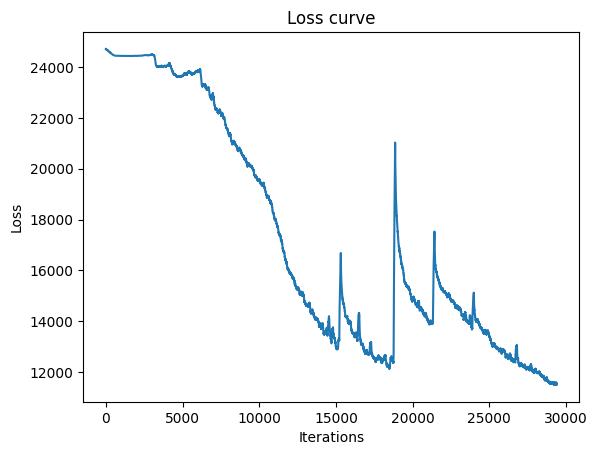

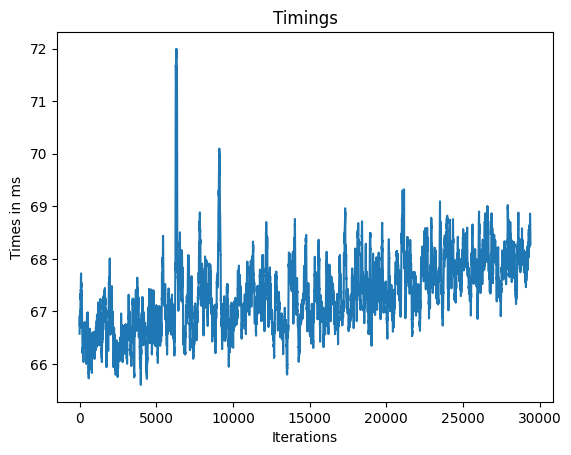

tensor([[ 0.3843, -0.1620,  0.7514,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1620,  0.6516, -0.4441,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7514, -0.4441,  3.1474,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.1700, -0.4635, -0.8682],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4635,  4.0213,  4.8263],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.8682,  4.8263,  6.3289]])
ALSO WTW
[[ 5.6277237  -0.36851457 -0.54282916 ... -0.16646552  0.34649113
  -0.45158118]
 [-0.36851457  4.680814   -1.8415097  ...  0.49153417  0.0588408
  -0.3588149 ]
 [-0.54282916 -1.8415097   4.7261925  ...  0.72661173 -0.20085743
  -0.958376  ]
 ...
 [-0.16646552  0.49153417  0.72661173 ...  7.094252   -0.6590135
   0.5076693 ]
 [ 0.34649113  0.0588408  -0.20085743 ... -0.6590135   5.8479466
  -0.879714  ]
 [-0.45158118 -0.3588149  -0.958376   ...  0.5076693  -0.879714
   6.328936  ]]


In [46]:
Handles_post.to_device(device)
Handles_pre.to_device(device)
Handles_pre.eval()
t_O = torch.tensor(np_object["ObjectSamplePts"]).to(device)

# Compute the moving average
window_size = 100
ma = moving_average(losses[500:], window_size)

# Plot the loss curve
plt.plot(ma)
plt.title('Loss curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

if timings is not None:
    # Compute the moving average
    window_size = 100
    ma = moving_average(timings[500:], window_size)

    # Plot the loss curve
    plt.plot(ma)
    plt.title('Timings')
    plt.xlabel('Iterations')
    plt.ylabel('Times in ms')
    plt.show()


np_W0, np_X0, np_G0 = test(Handles_pre, t_O, int(t_O.shape[0]))
np_W, np_X, np_G = test(Handles_post, t_O, int(t_O.shape[0]))

X0 = torch.tensor(np_X)
W  = torch.tensor(np_W)

num_handles = W.shape[1]
num_samples = X0.shape[0]
X03 = torch.cat((X0, torch.ones(X0.shape[0]).unsqueeze(-1)), dim=1)
X03reps = X03.repeat_interleave(3, dim=0).repeat((1, 3*num_handles))
Wreps = W.repeat_interleave(12, dim=1).repeat_interleave(3, dim=0)
WX03reps = torch.mul(Wreps, X03reps)
Bsetup = torch.kron(torch.ones(num_samples).unsqueeze(-1), torch.eye(3)).repeat((1,num_handles))
Bmask = torch.repeat_interleave(Bsetup, 4, dim=1)

B = torch.mul(Bmask, WX03reps)
print(B.T @ B)
print("ALSO WTW")
print(np_W.T@np_W)

In [47]:
global points 
global weights
points = np_X 
weights = np_W 

global handle_num
global epoch_num
handle_num = 0
epoch_num = len(epoch_list)

max_all_w = np.max(np.max(weights))
min_all_w = np.min(np.min(weights))

# Combo box to choose from options
# There, the options are a list of strings in `ui_options`,
# and the currently selected element is stored in `ui_options_selected`.
def callback():
    global handle_num, points, weights, epoch_num, epoch_list
    changed2, epoch_num = psim.SliderInt("Epoch:", epoch_num, v_min=0, v_max=len(epoch_list))
    changed1, handle_num = psim.SliderInt("Handles:", handle_num, v_min=0, v_max=weights.shape[1]-1)
    if changed1 or changed2:
        ii = int(handle_num)
        if epoch_num == len(epoch_list):        
            weights, points, np_G = test(Handles_post, t_O, int(t_O.shape[0]))
        else:
            ei = epoch_list[epoch_num]
            Handles_its = torch.load(object_name+"/"+training_name+"-training" + "/Handles_post-its-"+str(ei))
            Handles_its.to_device(device)
            weights, points,  np_G = test(Handles_its, t_O, int(t_O.shape[0]))

        w = weights[:, ii]
        # ps_cloud.add_scalar_quantity("Weight: "+str(ii), w, enabled=True)
        # Normalize the weights to the range [0, 1]
        # w_norm = (w - min_all_w) / (max_all_w - min_all_w)
        ps_cloud.update_point_positions(points)
        ps_cloud.add_scalar_quantity("Weight: "+str(ii), w, enabled=True, datatype="symmetric")
        # color_mat = np.column_stack((w_norm, w_norm, w_norm))
        # color_mat[:,1:2] = 1
        # # print(color_mat)
        # ps_cloud.add_color_quantity("weights: "+str(ii), color_mat, enabled=True)

In [28]:
# Show the plot
if show_plot:
    ps.init()
    ps.remove_all_structures()
    ps_cloud = ps.register_point_cloud("samples", points, enabled=True)
    ps_cloud.add_scalar_quantity("Weight: "+str(0), weights[:,0], enabled=True, datatype="symmetric")
    ps_unit_cloud = ps.register_point_cloud("UnitSphere",  np.array([[0,0,0],[1,0,0]]), enabled=True, radius=1)
    ps.set_user_callback(callback)
    ps.show()

## 5. Phyisical Simulation

From the file `PhysicsSimMultiObject_5.py`

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random, os, sys, json
from SimplicitHelpers import *
from PhysicsHelpers import *

In [49]:
def E_Coll_Penalty(X, col_indices):
    col_penalty = torch.tensor(0, dtype=torch.float32, device=device)

    for i in range(torch.max(col_indices)):
        j = i+1
        inds_where_object_i = torch.nonzero(col_indices == i).squeeze()
        inds_where_object_j = torch.nonzero(col_indices == j).squeeze()

        M = X[inds_where_object_i, :]
        V = X[inds_where_object_j, :]

        col_penalty += torch.sum(-1*torch.log(torch.cdist(M, V, p=2)**2))
    return col_penalty

def E_pot(X0,  W, Faces, YMs, Ts, Handles):
    poisson = float(0.45)
    mus = YMs/(2*(1+poisson)) #shead modulus
    lams = YMs*poisson/((1+poisson)*(1-2*poisson)) #

    def elastic_energy(F, mu, lam):
        E = neohookean_E2(mu, lam, F[0,:,:])
        return E
    
    def x(x0):
        x0_i = x0.unsqueeze(0)
        x03 = torch.cat((x0_i, torch.tensor([[1]], device=device)), dim=1)
        t_W = torch.cat((Handles.getAllWeightsSoftmax(x0_i), torch.tensor([[1]]).to(device)), dim=1).T
        
        def inner_over_handles(T, w):
            return w*T@x03.T

        wTx03s = torch.vmap(inner_over_handles)(Ts, t_W)
        x_i =  torch.sum(wTx03s, dim=0)
        return x_i.T +x0_i
    
    pt_wise_Fs = torch.vmap(torch.func.jacrev(x), randomness="same")(X0)
    pt_wise_E = torch.vmap(elastic_energy, randomness="same")(pt_wise_Fs, mus, lams)
    totE = (np_object["ObjectVol"]/X0.shape[0])*pt_wise_E.sum()
    return totE

def penalty(X0, x0_flat, B, J, z):

    global simulation_iteration, move_mask, dt, barrier_T
    x_flat = B@z + x0_flat

    #### Fixed vertices
    totE = float(scene["penalty_spring_fixed_weight"])*z.T@B.T@J@J.T@B@z

    # collE = float(scene["penalty_log_barrier_collisions"])*E_Coll_Penalty(x_flat.reshape(-1,3), col_indices=ColMap)

    ##### Moving vertices
    movE = torch.tensor([[0]], dtype=torch.float32).to(device)
    if float(scene["penalty_spring_moving_weight"])>0:
        moving_verts = x0_flat[move_mask].reshape(-1,3).detach()
        l_dict = {"moving_verts": moving_verts, "dt":dt, "simulation_iteration": simulation_iteration}
        exec(scene["SimplicitObjects"][0]["MoveBC_code"], globals(), l_dict)
        updated_vert_positions = l_dict["updated_vert_positions"]
        if updated_vert_positions != None:
            Xs = x_flat[move_mask].reshape(-1, 3)
            movE = float(scene["penalty_spring_moving_weight"])*torch.sum(torch.square(updated_vert_positions - Xs))

    
    #pokes
    pokyE = torch.tensor([[0]], dtype=torch.float32).to(device)
    if len(scene["CollisionObjects"])>0:
        dist_to_poky = torch.tensor([0], dtype=torch.float32).to(device)
        for p in range(len(scene["CollisionObjects"])):           
            collision_object = torch.tensor(scene["CollisionObjects"][p]["Position"], dtype=torch.float32, device=device)
            l_dict = {"collision_obj": collision_object, "dt":dt, "simulation_iteration": simulation_iteration}
            exec(scene["CollisionObjects"][p]["Update_code"], globals(), l_dict)
            collision_object = l_dict["pos"]
            dist_to_poky = torch.sqrt(torch.sum((x_flat.reshape(-1,3) - collision_object)**2, dim=1))
            min_dist_to_poky = torch.min(dist_to_poky)
            collision_object_rad = float(scene["CollisionObjects"][0]["Radius"])
            if torch.min(dist_to_poky)<collision_object_rad:
                pokyE += torch.tensor(float("inf"), dtype=torch.float32).to(device)
            else:
                log_dist_to_poky =-(float(scene["BarrierInitStiffness"])/(float(scene["BarrierDec"])**barrier_T))*torch.log(min_dist_to_poky - collision_object_rad) #log barrier is inf at collision_object_rad
                if log_dist_to_poky>0:
                    pokyE += log_dist_to_poky
                # pos_indx = log_dist_to_poky>0
                # pokyE += 1*torch.sum(log_dist_to_poky[pos_indx])


    #### Floor
    floorE = torch.tensor([[0]], dtype=torch.float32).to(device)
    if float(scene["penalty_spring_floor_weight"])>0:
        ys = x_flat[1::3]
        masked_values = ys[ys<float(scene["Floor"])] - float(scene["Floor"])
        floorE = float(scene["penalty_spring_floor_weight"])*torch.sum(masked_values**2)

    if len(scene["CollisionObjects"])>0:
        print("         PokeE: ", pokyE, barrier_T, torch.min(dist_to_poky))
    return totE + floorE + movE + pokyE# + collE

def potential_energy(Phi, W, z, newx, Mg, X0, Faces, YMs,  x0_flat, J, B, Handles):  
    pe = penalty(X0, x0_flat, B, J, z)
    T = z.reshape(-1, 3,4)
    le = Phi(X0, W, Faces, YMs, T, Handles) #E_pot(X0, T, Handles)
    ge = newx.T @ Mg
    return le + ge + pe

def line_search(func, x, direction, gradient, alpha=0.5, beta=0.5):
    t = 10.0  # Initial step size
    for _ in range(int(scene["LSIts"])):
        x_new = x + t * direction
        f_new = func(x_new)
        f = func(x)
        gTd = gradient.T@direction
        if f_new <= f + alpha * t * gTd:
            return t
        t *= beta  # Reduce the step size

    return t  # Return the final step size if max_iters is reached

def getBColiNorm(W, X0, i):
    # B matrix is the modes
    # 3*|verts| x num dofs (|z|)
    
    t_ind = int(i/12) #row i gets weights from handle t_ind

    def nzBColi(wt_n, x_n):
        if i%4 ==0:
            return wt_n*x_n[0]
        elif i%4 ==1:
            return wt_n*x_n[1]
        elif i%4 ==2:
            return wt_n*x_n[2]
        elif i%4 ==3:
            return wt_n
    
    nonzero_col_entries = torch.vmap(nzBColi, randomness="same")(W[:, t_ind], X0)

    return torch.sum(nonzero_col_entries.square())

def simulate(np_X, Faces, np_YMs, np_PRs, np_Rho, WW, Phi, Handles):
    global simulation_iteration, move_mask, dt, barrier_T
    
    states = []
    
    #nx2 sample points
    X0 = torch.tensor(np_X, dtype=torch.float32, requires_grad = True, device=device)
    ones_column = torch.ones(X0.shape[0], 1).to(device)
    W = torch.cat((Handles.getAllWeightsSoftmax(X0), ones_column), dim=1)

    tYMs = torch.tensor(np_YMs, dtype=torch.float32).to(device)
    tPRs = torch.tensor(np_PRs, dtype=torch.float32).to(device)
    tFaces = torch.tensor(Faces).to(device)

    # Use torch.nn.functional.one_hot to create the one-hot matrix for object-wise rigid deformations
    # one_hot_matrix = torch.nn.functional.one_hot(tColMap, num_classes=torch.max(tColMap)+1)
    # W = torch.cat((W, one_hot_matrix), dim=1)
    
    # number of handles + 1 for hard coded rigid translations
    num_handles = W.shape[1]
    num_samples = np_X.shape[0]
    

    #### Set moving boundary conditions
    move_mask = torch.zeros(num_samples*3, dtype=torch.bool)
    l_dict = {"X0": X0}
    exec(scene["SimplicitObjects"][0]["SetMovingBC_code"], globals(), l_dict)
    indices = l_dict["indices"]
    indices = (3*indices).repeat_interleave(3)
    indices[1::3] += 1
    indices[2::3] += 2; 
    move_mask[indices] = True 

    #### Set fixed boundary conditions
    # Create a mask to identify rows to be REMOVED
    mask = torch.zeros(num_samples*3, dtype=torch.bool)
    # execute code in json file to set object's fixed bc
    l_dict = {"X0": X0}
    exec(scene["SimplicitObjects"][0]["SetFixedBC_code"], globals(), l_dict)
    indices = l_dict["indices"]
    indices = (3*indices).repeat_interleave(3)
    indices[1::3] += 1
    indices[2::3] += 2; 
    # Create a mask to identify rows to be removed; 
    mask[indices] = True
    
    #### Create an nxn identity matrix
    Id = torch.eye(num_samples*3)
    # Use the mask to remove rows from the identity matrix
    redID = Id[mask]
    J = redID.T.to(device)

    # 2*num samples gravities per sample point
    grav = torch.zeros(num_samples*3).to(device)
    grav[0::3] = float(scene["Gravity"][0]) #acc from gravity
    grav[1::3] = float(scene["Gravity"][1]) #acc from gravity
    grav[2::3] = float(scene["Gravity"][2]) #acc from gravity
    
    
    #total mass of object
    density_m = torch.tensor(np_Rho, dtype=torch.float32, device=device) #kg/m^2
    sample_vol = np_object["ObjectVol"]/density_m.shape[0]
    
    #mass matrix created  from masses assuming uniform density over mesh
    m = density_m*sample_vol#torch.sum((total_m/W.shape[0])*W, dim=1).to(device)
    M = torch.diag(m.repeat_interleave(3)).to(device).float()

    #total mass of object
    # density_m = float(10) #kg/m^2
    # total_m = density_m*np_object["ObjectVol"]
    
    # #mass matrix created  from masses assuming uniform density over mesh
    # m = (total_m/X0.shape[0])*torch.ones(X0.shape[0], dtype=torch.float32, device=device)#torch.sum((total_m/W.shape[0])*W, dim=1).to(device)
    # M = torch.diag(m.repeat_interleave(3)).to(device).float()
        
    # affine dofs and velocities
    z = torch.tensor([[0,0,0,0],[0,0,0,0],[0,0,0,0]], dtype=torch.float32, requires_grad=True, device=device).flatten().repeat(num_handles).unsqueeze(-1)
    z_dot = torch.zeros_like(z).to(device)

    # 3*samples x 4*3*handles
    X03 = torch.cat((X0, torch.ones(X0.shape[0], device=device).unsqueeze(-1)), dim=1)
    X03reps = X03.repeat_interleave(3, dim=0).repeat((1, 3*num_handles))
    Wreps = W.repeat_interleave(12, dim=1).repeat_interleave(3, dim=0)
    WX03reps = torch.mul(Wreps, X03reps)
    Bsetup = torch.kron(torch.ones(num_samples).unsqueeze(-1), torch.eye(3)).repeat((1,num_handles)).to(device)
    Bmask = torch.repeat_interleave(Bsetup, 4, dim=1).to(device)

    B = torch.mul(Bmask, WX03reps)

    x0_flat = (X0.flatten().unsqueeze(-1))

    BMB = B.T@M@B
    BJMJB = BMB #B.T@J@J.T@M@J@J.T@B

    Mg = M@grav
    states.append(z.clone().cpu().detach())

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    for step in range(int(scene["Steps"])):
        # set u prev at start of step
        z_prev = z.clone().detach()

        barrier_T = 0
        for barrier_its in range(int(scene["BarrierIts"])):
            for iter in range(int(scene["NewtonIts"])):
                # zero out the gradients of u
                z.grad = None

                def partial_newton_E(z): 
                    newx = B@z + x0_flat
                    PE = potential_energy(Phi,W, z, newx, Mg, X0, tFaces, tYMs, x0_flat, J, B, Handles)
                    return 0.5*z.T@BJMJB@z - z.T@BJMJB@ z_prev - dt*z.T@BJMJB@ z_dot + dt*dt*PE

                
                # Newton's method minimizes this energy
                newton_E = partial_newton_E(z)
                newton_gradE = torch.autograd.grad(newton_E, inputs = z, allow_unused=True)

                newton_hessE = torch.autograd.functional.hessian(partial_newton_E, inputs = z)

                # 18885544732 PEC
                # print(newton_E)
                # print(newton_gradE)
                # print(torch.sum(newton_hessE))
                with torch.no_grad():
                    newton_H = newton_hessE[:,0,:,0]

                    if bool(scene["HessianSPDFix"]):
                        # Simple PSD fix
                        L, V = torch.linalg.eig(newton_H)
                        L = torch.real(L)
                        L[L<1e-2] = 1e-2
                        L = torch.complex(L, torch.zeros_like(L))
                        fixed_H = torch.real(V@torch.diag(L)@torch.linalg.inv(V))
                    else:
                        fixed_H = newton_H
                
                    # print(step, torch.dist(fixed_H, newton_H))

                    newton_g = torch.cat(newton_gradE)
                    newx = B@z + x0_flat
                    # Solve for x using J and g
                    dz = -torch.linalg.solve(fixed_H[:, :], newton_g[:])

                    print(torch.norm(newton_g))
                    if (torch.norm(newton_g)<2e-4):
                        print("-----------Converged")
                        break
                    
                    # Line Search
                    alpha = line_search(partial_newton_E, z, dz, newton_g)
        
                    print("ls alpha: ", alpha)
                    # Update positions 
                    z[:] += alpha*dz

            with torch.no_grad():
                z_dot = (z - z_prev)/dt

            barrier_T += 1
        states.append(z.clone().cpu().detach())
        simulation_iteration += 1
        torch.save(states, name_and_training_dir+"/" + scene_name + "-sim_states")

    return states, X0.cpu().detach(), W.detach()

In [50]:
scene = json.loads(open(f'scenes/{scene_name}.json', "r").read())

t_O = torch.tensor(np_object["ObjectSamplePts"], dtype=torch.float32).to(device)
# t_YMs = torch.tensor(np_object["ObjectYMs"], dtype=torch.float32).to(device)
# t_Rho = torch.tensor(np_object["ObjectRho"], dtype=torch.float32).to(device)
simulation_iteration = 0
barrier_T = 0

#timestep 
dt = float(scene["dt"]) #s
move_mask = None
explicit_W = None # torch.tensor(np_object["biharmonic_weights"]).float().to(device)#Handles.getAllWeightsSoftmax(X0)

In [51]:
random_batch_indices = np.random.randint(0, np_object["ObjectSamplePts"].shape[0], size=int(scene["NumCubaturePts"])) 
np_V = None #np_object["surfV"][:, 0:3]
np_F = 0 #np_object["surfF"]
np_X = np_object["ObjectSamplePts"][:, 0:3][random_batch_indices, :]
np_YMs = np_object["ObjectYMs"][random_batch_indices, np.newaxis]
np_Rho = np_object["ObjectRho"][random_batch_indices, np.newaxis]
np_PRs = np_object["ObjectPRs"][random_batch_indices, np.newaxis]
torch.save(np_X, name_and_training_dir+"/" + scene_name + "-sim_X0")
torch.save(np_YMs, name_and_training_dir+"/" + scene_name + "-sim_W")

states,  t_X0, explicit_W = simulate(np_X, np_F, np_YMs, np_PRs, np_Rho, explicit_W, E_pot, Handles_post)

torch.save(states, name_and_training_dir+"/" + scene_name + "-sim_states")
torch.save(t_X0, name_and_training_dir+"/" + scene_name + "-sim_X0")
torch.save(explicit_W, name_and_training_dir+"/" + scene_name + "-sim_W")

tensor(0.1041, device='cuda:0')
ls alpha:  0.625
tensor(0.0390, device='cuda:0')
ls alpha:  0.625
tensor(0.0146, device='cuda:0')
ls alpha:  0.625
tensor(0.0055, device='cuda:0')
ls alpha:  2.5
tensor(0.0082, device='cuda:0')
ls alpha:  1.25
tensor(0.0021, device='cuda:0')
ls alpha:  0.01953125
tensor(0.0020, device='cuda:0')
ls alpha:  0.009765625
tensor(0.0020, device='cuda:0')
ls alpha:  0.0048828125
tensor(0.0020, device='cuda:0')
ls alpha:  0.00244140625
tensor(0.0020, device='cuda:0')
ls alpha:  0.001220703125
tensor(0.2062, device='cuda:0')
ls alpha:  0.625
tensor(0.0773, device='cuda:0')
ls alpha:  0.625
tensor(0.0290, device='cuda:0')
ls alpha:  0.625
tensor(0.0109, device='cuda:0')
ls alpha:  0.625
tensor(0.0041, device='cuda:0')
ls alpha:  0.625
tensor(0.0015, device='cuda:0')
ls alpha:  2.5
tensor(0.0023, device='cuda:0')
ls alpha:  0.00244140625
tensor(0.0023, device='cuda:0')
ls alpha:  0.001220703125
tensor(0.0023, device='cuda:0')
ls alpha:  0.0006103515625
tensor(0.002

## 6. Animate with Polyscope

In [94]:
device = "cpu" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
loaded_Handles = torch.load(object_name+"/"+training_name+"-training" + "/Handles_post",  map_location=torch.device(device))
loaded_X0 = torch.tensor(np_object["ObjectSamplePts"],  dtype=torch.float32)
# loaded_X0 = torch.load(object_name+"/"+training_name+"-training" +"/"+str(args[2])+"-sim_X0", map_location=torch.device(device))
loaded_ym = torch.tensor(np_object["ObjectYMs"]).detach().numpy()
# loaded_ym = torch.ones(loaded_X0.shape[0])
loaded_states = torch.load(object_name+"/"+training_name+"-training" +"/"+f"{scene_name}-sim_states", map_location=torch.device(device))

showPointcloud = True
showUniformSample = True 
showReconstruction = False

def getX(Ts, l_X0, l_W):
    def x(x0, tW):
        x0_i = x0.unsqueeze(0)
        x03 = torch.cat((x0_i, torch.tensor([[1]], device=device)), dim=1)
        Ws = tW.T
        
        def inner_over_handles(T, w):
            return w*T@x03.T

        wTx03s = torch.vmap(inner_over_handles)(Ts.to(device), Ws)
        x_i =  torch.sum(wTx03s, dim=0)
        return x_i.T + x0_i
    
    X = torch.vmap(x, randomness="same")(l_X0.to(device), l_W.to(device))
    return X[:,0,:].cpu().detach().numpy()


frame_num = 0
ps.init()

#set bounding box for floor plane and scene extents
ps.set_automatically_compute_scene_extents(False)
ps.set_length_scale(1.)
low = np.array((float(scene["BoundingX"][0]), 
                float(scene["BoundingY"][0]), 
                float(scene["BoundingZ"][0]))) 

high = np.array((float(scene["BoundingX"][1]), 
                 float(scene["BoundingY"][1]), 
                 float(scene["BoundingZ"][1])))
ps.set_bounding_box(low, high)
ps.set_ground_plane_height_factor(-float(scene["Floor"]) + float(scene["BoundingY"][0]), is_relative=False) # adjust the plane height


ps_cloud = ps.register_point_cloud("samples", loaded_X0.cpu().numpy(), enabled=True)
ps_cloud.add_scalar_quantity("yms", loaded_ym, enabled=True)


if (len(scene["CollisionObjects"])>0):
    pokes = np.zeros((len(scene["CollisionObjects"]), 3))
    rad = scene["CollisionObjects"][0]["Radius"]
    for p in range(len(scene["CollisionObjects"])):
        collision_object = torch.tensor(scene["CollisionObjects"][p]["Position"], dtype=torch.float32, device=device)
        pokes[p,:] = collision_object
    ps_pokes = ps.register_point_cloud("Pokes", pokes, radius=rad, enabled=True)


computed_W_X0 =  torch.cat((loaded_Handles.getAllWeightsSoftmax(loaded_X0), torch.ones(loaded_X0.shape[0], 1)), dim=1) 

def callback():
   global frame_num, loaded_states, computed_W, loaded_all, ps_cloud, ps_surf#, ps_vol#, ps_surf
   changed, frame_num = psim.SliderInt("Frame", frame_num, v_min=0, v_max=len(loaded_states)-1)
   if changed:
      Ts = loaded_states[frame_num].reshape(-1, 3,4)
      X = getX(Ts, loaded_X0, computed_W_X0)
      ps_cloud.update_point_positions(X)

      if (len(scene["CollisionObjects"])>0):
        for p in range(len(scene["CollisionObjects"])):
                collision_object = np.array(scene["CollisionObjects"][p]["Position"])
                l_dict = {"collision_obj" : collision_object, "dt" : 0.1, "simulation_iteration" : frame_num}
                exec(scene["CollisionObjects"][p]["Update_code"], None, l_dict)
                collision_object = l_dict["pos"]
                pokes[p,:] = collision_object
        ps_pokes.update_point_positions(pokes)


ps.set_user_callback(callback)
ps.show()

In [99]:
# Ts.shape, loaded_X0.shape, computed_W_X0.shape, loaded_x0.shape, computed_w_x.shape

(torch.Size([40, 3, 4]),
 torch.Size([105420, 3]),
 torch.Size([105420, 41]),
 torch.Size([303208, 3]),
 torch.Size([303208, 41]))

In [103]:
device = "cpu" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
loaded_Handles = torch.load(object_name+"/"+training_name+"-training" + "/Handles_post",  map_location=torch.device(device))
loaded_X0 = gaussians.get_xyz.to(device).to(torch.float32)
loaded_ym = torch.tensor(np_object["ObjectYMs"]).detach().numpy()
loaded_states = torch.load(object_name+"/"+training_name+"-training" +"/"+f"{scene_name}-sim_states", map_location=torch.device(device))

def getX(Ts, l_X0, l_W):
    def x(x0, tW):
        x0_i = x0.unsqueeze(0)
        x03 = torch.cat((x0_i, torch.tensor([[1]], device=device)), dim=1)
        Ws = tW.T
        
        def inner_over_handles(T, w):
            return w*T@x03.T

        wTx03s = torch.vmap(inner_over_handles)(Ts.to(device), Ws)
        x_i =  torch.sum(wTx03s, dim=0)
        return x_i.T + x0_i
    
    X = torch.vmap(x, randomness="same")(l_X0.to(device), l_W.to(device))
    return X[:,0,:].cpu().detach().numpy()


frame_num = 0

if (len(scene["CollisionObjects"])>0):
    pokes = np.zeros((len(scene["CollisionObjects"]), 3))
    rad = scene["CollisionObjects"][0]["Radius"]
    for p in range(len(scene["CollisionObjects"])):
        collision_object = torch.tensor(scene["CollisionObjects"][p]["Position"], dtype=torch.float32, device=device)
        pokes[p,:] = collision_object

computed_W_X0 =  torch.cat((loaded_Handles.getAllWeightsSoftmax(loaded_X0), torch.ones(loaded_X0.shape[0], 1)), dim=1) 


def callback():
   global frame_num, loaded_states, computed_W, loaded_all, ps_cloud, ps_surf#, ps_vol#, ps_surf
   changed, frame_num = psim.SliderInt("Frame", frame_num, v_min=0, v_max=len(loaded_states)-1)
   if changed:
      Ts = loaded_states[frame_num].reshape(-1, 3,4)
      X = getX(Ts, loaded_X0, computed_W_X0)
      ps_cloud.update_point_positions(X)

      if (len(scene["CollisionObjects"])>0):
        for p in range(len(scene["CollisionObjects"])):
                collision_object = np.array(scene["CollisionObjects"][p]["Position"])
                l_dict = {"collision_obj" : collision_object, "dt" : 0.1, "simulation_iteration" : frame_num}
                exec(scene["CollisionObjects"][p]["Update_code"], None, l_dict)
                collision_object = l_dict["pos"]
                pokes[p,:] = collision_object
        ps_pokes.update_point_positions(pokes)


# -- Show in Polyscope --
          
# ps.init()
# #set bounding box for floor plane and scene extents
# ps.set_automatically_compute_scene_extents(False)
# ps.set_length_scale(1.)
# low = np.array((float(scene["BoundingX"][0]), 
#                 float(scene["BoundingY"][0]), 
#                 float(scene["BoundingZ"][0]))) 

# high = np.array((float(scene["BoundingX"][1]), 
#                  float(scene["BoundingY"][1]), 
#                  float(scene["BoundingZ"][1])))
# ps.set_bounding_box(low, high)
# ps.set_ground_plane_height_factor(-float(scene["Floor"]) + float(scene["BoundingY"][0]), is_relative=False) # adjust the plane height


# ps_cloud = ps.register_point_cloud("samples", loaded_X0.cpu().detach().numpy(), enabled=True)
# ps.set_user_callback(callback)
# ps.show()

In [179]:
import ipywidgets
from ipywidgets import Layout
import kaolin
from thirdparty.gausplat.gaussian_renderer import render, GaussianModel
from gaussian_splat_utils import convert_kaolin_camera

gaussians = load_checkpoint(OUTPUT_FOLDER)
camera = try_load_kaolin_camera(OUTPUT_FOLDER)
renderer = GaussianSplatsRendererSetup(gaussians, camera)
time_slider = ipywidgets.IntSlider(
    value=0,
    min=0, max=50.0,
    step=1,
    description=f'Time',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    # readout_format='.3f',
    layout=Layout(width='1000px')
)

scaling_property = renderer.scaling_property
opacity_property = renderer.opacity_property
scaling_slider = renderer.scaling_slider
opacity_slider = renderer.opacity_slider
attenuate_slider = renderer.attenuate_slider
rescale_slider = renderer.rescale_slider
pipeline = renderer.pipeline
background = renderer.background


def timed_render_kaolin(kaolin_cam):
    """Same rendering as above, but we subsample gaussians based on their scale."""
    # Select only the gaussians with radius below value
    frame_num = time_slider.value
    Ts = loaded_states[frame_num].reshape(-1, 3,4)
    X = getX(Ts, loaded_X0, computed_W_X0)
    
    scale_min_mask = scaling_property.min(dim=1)[0] > scaling_slider.value[0]
    scale_max_mask = scaling_property.max(dim=1)[0] < scaling_slider.value[1]
    scale_mask = scale_min_mask & scale_max_mask
    opacity_min_mask = opacity_property.min(dim=1)[0] > opacity_slider.value[0]
    opacity_max_mask = opacity_property.max(dim=1)[0] < opacity_slider.value[1]
    opacity_mask = opacity_min_mask & opacity_max_mask
    mask = scale_mask & opacity_mask
    tmp_gaussians = GaussianModel(gaussians.max_sh_degree)
    tmp_gaussians._xyz = torch.from_numpy(X).cuda()[mask, :]
    tmp_gaussians._features_dc = gaussians._features_dc[mask, ...]
    tmp_gaussians._features_rest = gaussians._features_rest[mask, ...] * attenuate_slider.value
    tmp_gaussians._opacity = gaussians._opacity[mask, ...]
    tmp_gaussians._scaling = gaussians._scaling[mask, ...] * rescale_slider.value
    tmp_gaussians._rotation = gaussians._rotation[mask, ...]
    tmp_gaussians.active_sh_degree = gaussians.max_sh_degree

    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, tmp_gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

def handle_slider(e):
    renderer.visualizer.out.clear_output()
    with renderer.visualizer.out:
        renderer.visualizer.render_update()

# Instantiate visualizer with this custom render function
# camera.change_coordinate_system(
#     torch.tensor(
#         [[1, 0, 0],
#          [0, 0, -1],
#          [0, 1, 0]])
# )
# pitch=np.pi/2, yaw=np.pi/2
# camera.rotate(roll=np.pi/8)
focus_at = (camera.cam_pos() - 4. * camera.extrinsics.cam_forward()).squeeze()
renderer.visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(camera), timed_render_kaolin,
    focus_at=focus_at, world_up_axis=1, max_fps=12)
renderer.visualizer.render_update()

scaling_slider.observe(handle_slider, names='value')
opacity_slider.observe(handle_slider, names='value')
attenuate_slider.observe(handle_slider, names='value')
rescale_slider.observe(handle_slider, names='value')
time_slider.observe(handle_slider, names='value')

display(
    renderer.visualizer.canvas,
    time_slider,
    # renderer.visualizer.out,
    renderer.scaling_slider,
    renderer.opacity_slider,
    renderer.attenuate_slider,
    renderer.rescale_slider
)

Canvas(height=512, width=512)

IntSlider(value=0, description='Time', layout=Layout(width='1000px'), max=50)

FloatRangeSlider(value=(-9.14421558380127, -1.6849740743637085), description='Log Scale:', layout=Layout(width…

FloatRangeSlider(value=(0.0013126314152032137, 0.9999988079071045), description='Opacity:', layout=Layout(widt…

FloatSlider(value=1.0, description='SH+-', layout=Layout(width='1000px'), max=2.0, readout_format='.3f', step=…

FloatSlider(value=1.0, description='Rescale', layout=Layout(width='1000px'), max=10.0, min=0.001, readout_form…